<a href="https://colab.research.google.com/github/Dan22dongwon/DeeplearningQuest/blob/main/10_Computer_Vision_Project(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#프로젝트 1: Image Classification

### 문제 1-1. VGG16 모델 구현하기

먼저 필요한 라이브러리를 불러옵니다.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

 ### 데이터를 준비

 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 2s 0us/step


train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장

In [4]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


train 데이터와 validation 데이터의 개수를 알아보

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


필요한 파라미터를 설정해 줍시다.
파라미터를 수정하면 성능을 높일 수 있으니 다양한 실험해보기

In [7]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

이미지를 확인하기 위해 데이터를 시각화하는 함수를 만들어 봅시다. 간단한 함수이기 때문에 자세한 코드 설명은 생략하겠습니다. 궁금하다면 구글링을 통해 각 코드가 어떤 역할을 하는지 찾아보세요.

In [8]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.

Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

In [9]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

```.flow_from_directory```를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다. 우리는 개와 고양이를 분류하는 task를 수행하기 때문에```class_mode```는 'binary'입니다. Classification task에 ```따라 class_mode```를 변경하시면 됩니다.

In [10]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [11]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

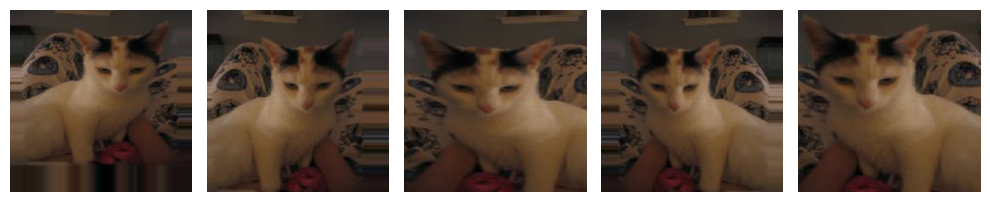

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [13]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [14]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


Validation 데이터를 확인해 봅시다. 크게 이미지와 정답 데이터로 구성이 되어 있습니다.

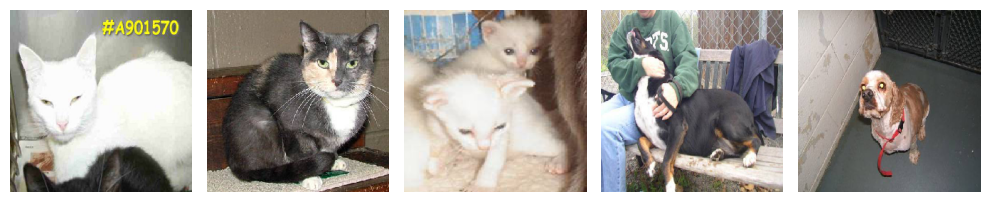

In [15]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [16]:
_[:5] # 정답 데이터

array([0., 0., 0., 1., 1.], dtype=float32)

문제 1-1. VGG16 모델 구현하기
이제 VGG16 모델을 구현해 볼 시간입니다. 바로 혼자서 모델을 구현하라고 하면 어렵겠죠? 그래서 참고할만한 모델 구현 코드를 아래에 적어 보았습니다. 실제 VGG16 모델과는 살짝 구조가 다르기 때문에 이미지를 보면서 어느 부분이 다른치 찾아 보는 것도 좋을 것 같습니다.

```
# 참고 코드

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

```

In [17]:
# 문제1-1. 이미지에 나온 VGG16 모델을 구현하세요.

input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496 

In [18]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

손실함수, optimizer, metric을 설정해 줍니다.

손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있습니다. optimizer도 Adam 외에 다양한 것을 사용할 수 있습니다. 자유롭게 바꿔보세요.

In [19]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

모델 학습을 시켜봅시다.
data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
만약 ```batch_size=20```이고 ```steps_per_epoch=100```일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.

> 일반적으로 (전체 데이터 길이/batch_size)를 ```steps_per_epoch```으로 설정합니다.

In [20]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 60s 351ms/step - loss: 59.6437 - binary_accuracy: 0.5025 - val_loss: 0.8174 - val_binary_accuracy: 0.4920
Epoch 2/5
125/125 [==============================] - 46s 367ms/step - loss: 0.7022 - binary_accuracy: 0.4890 - val_loss: 0.6954 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 45s 364ms/step - loss: 0.6955 - binary_accuracy: 0.5015 - val_loss: 0.6947 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 53s 423ms/step - loss: 0.6943 - binary_accuracy: 0.4995 - val_loss: 0.6936 - val_binary_accuracy: 0.5010
Epoch 5/5
125/125 [==============================] - 51s 404ms/step - loss: 0.6992 - binary_accuracy: 0.4955 - val_loss: 0.6926 - val_binary_accuracy: 0.5020


학습이 되었다면 시각화를 통해 정확도를 알아봅시다

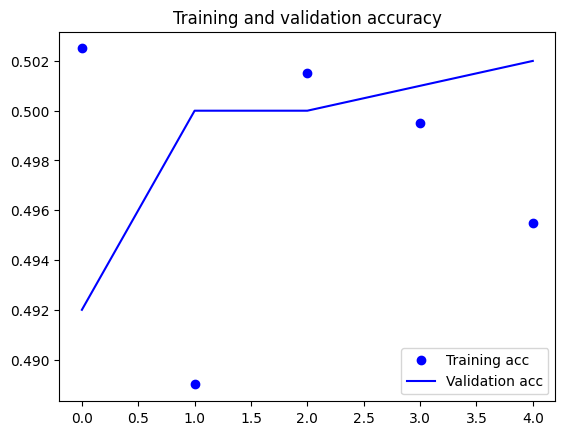

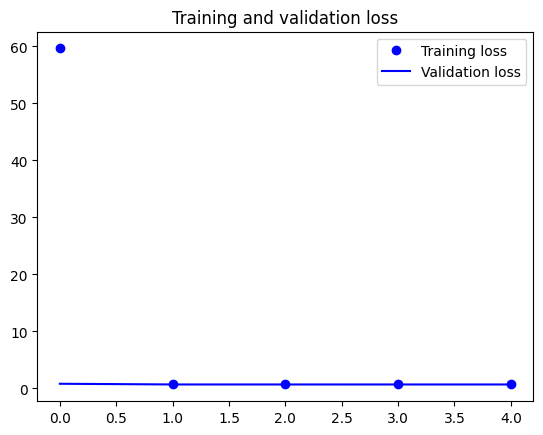

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

성능이 그리 좋지는 않습니다.

### 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 높일 수 있습니다. 다양한 실험을 통해 성능을 올려 보세요.

In [31]:
# 문제 1-2. hyperparameter 설정
# [[YOUR CODE]]
BATCH_SIZE = 100
IMG_SHAPE  = 150

In [32]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


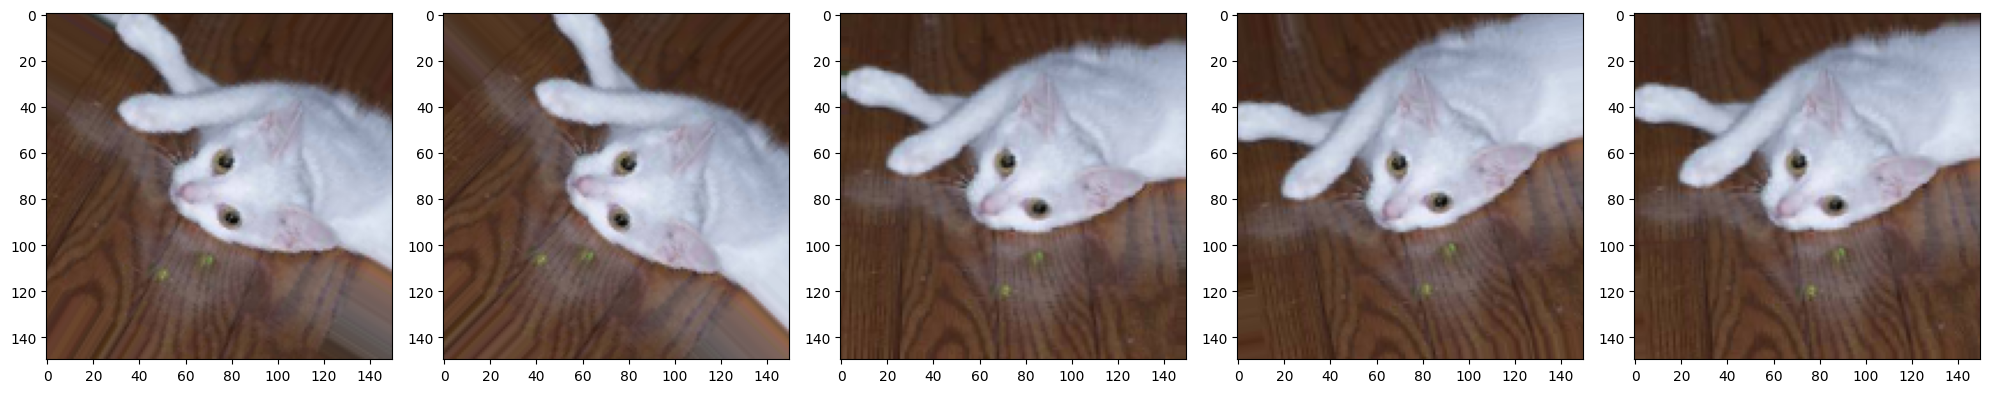

Found 2000 images belonging to 2 classes.


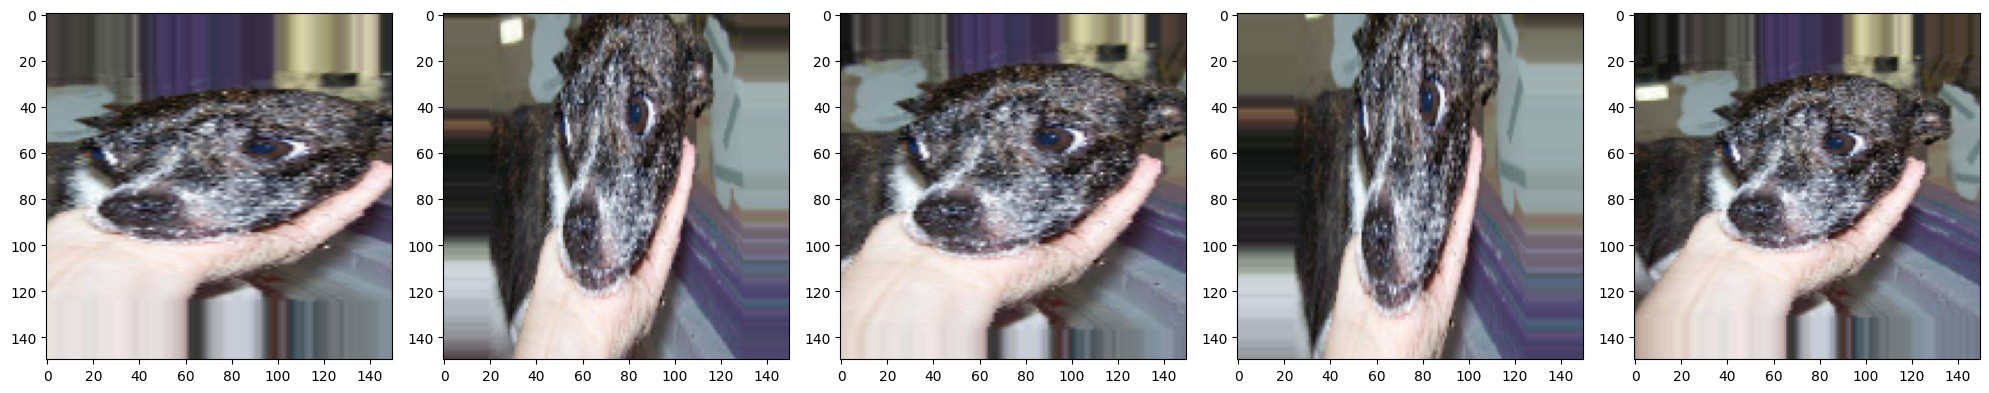

Found 2000 images belonging to 2 classes.


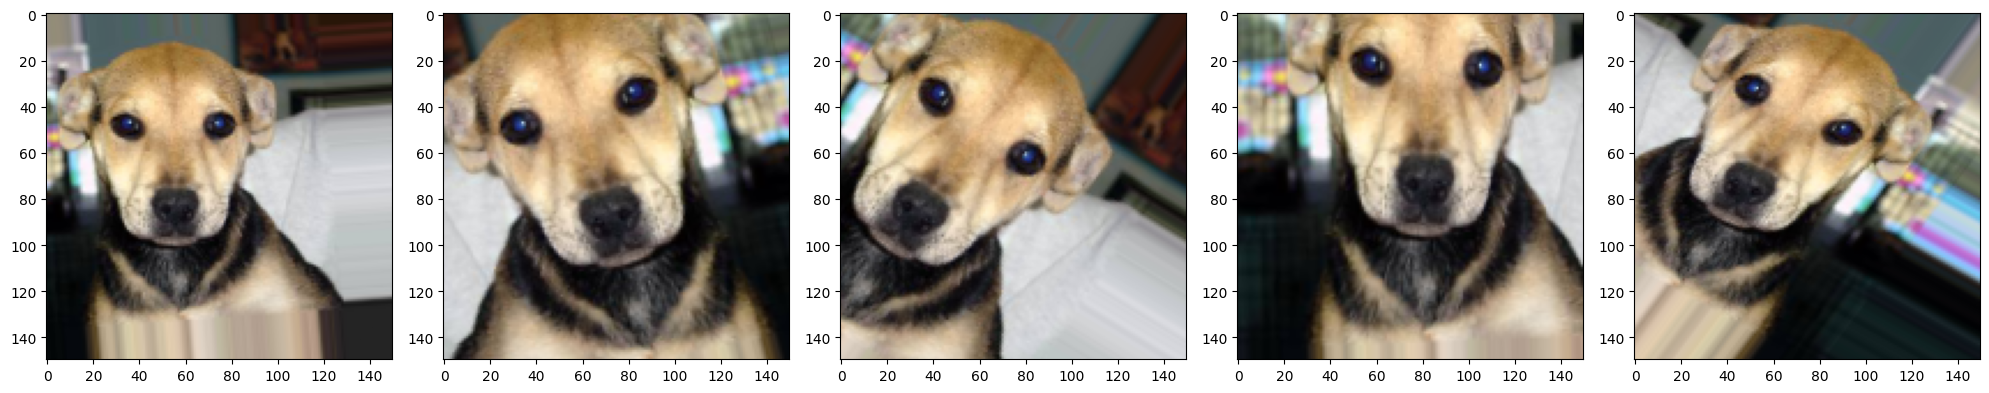

Found 1000 images belonging to 2 classes.


In [33]:
# 문제 1-2. 데이터 generator 생성 & Image Augmended

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))


image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

In [36]:
# 문제 1-2. 모델 구현


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)      0

In [37]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
# 모델 학습
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

<ipython-input-38-5f136babf74d>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
20/20 [==============================] - 25s 990ms/step - loss: 0.7444 - accuracy: 0.4980 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 21s 1s/step - loss: 0.6929 - accuracy: 0.5055 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - 27s 1s/step - loss: 0.6932 - accuracy: 0.5120 - val_loss: 0.6909 - val_accuracy: 0.5740
Epoch 4/100
20/20 [==============================] - 28s 1s/step - loss: 0.6887 - accuracy: 0.5475 - val_loss: 0.6814 - val_accuracy: 0.5400
Epoch 5/100
20/20 [==============================] - 21s 1s/step - loss: 0.6833 - accuracy: 0.5595 - val_loss: 0.6554 - val_accuracy: 0.6080
Epoch 6/100
20/20 [==============================] - 20s 995ms/step - loss: 0.6727 - accuracy: 0.5895 - val_loss: 0.6594 - val_accuracy: 0.5990
Epoch 7/100
20/20 [==============================] - 21s 1s/step - loss: 0.6848 - accuracy: 0.5605 - val_loss: 0.6718 - val_accuracy: 0.6110
Epoch 8

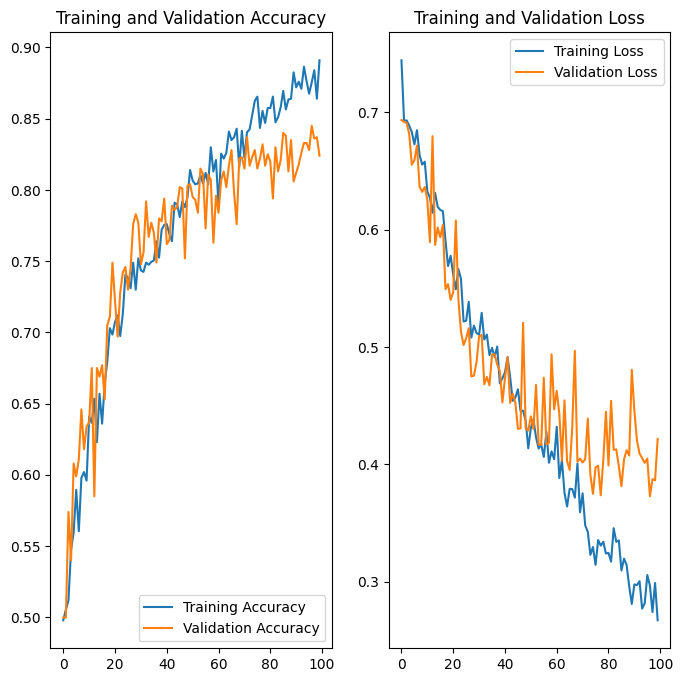

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()